## Ejemplo RRT (Rapidly Exploring Random Trees)

Adaptado de: https://github.com/AtsushiSakai/PythonRobotics/tree/master/PathPlanning/RRT

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np

### Clase para RRT

In [9]:
class RRT(object):
    """
    Class for RRT planning
    """
    class Node:
        """
        RRT Node
        """
        def __init__(self, x, y):
            self.x = x; self.y = y
            self.path_x = []; self.path_y = []
            self.parent = None

    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=3.0,
                 path_resolution=0.5, goal_sample_rate=5, max_iter=500):
        """
        Setting Parameters
          start - Start Position [x,y]
          goal - Goal Position [x,y]
          obstacleList - obstacle Positions [[x,y,size],...]
          randArea - Random Sampling Area [min,max]
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def planning(self, animation=False):
        """
        RRT path planning
        animation - flag for animation on or off
        """
        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]
            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_collision(new_node, self.obstacle_list):
                self.node_list.append(new_node)
            if animation and i % 5 == 0:
                self.draw_graph(rnd_node, animation)
            if self.calc_dist_to_goal(self.node_list[-1].x,
                                      self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(self.node_list[-1], self.end,
                                        self.expand_dis)
                if self.check_collision(final_node, self.obstacle_list):
                    return self.generate_final_course(len(self.node_list) - 1)
            if animation and i % 5:
                self.draw_graph(rnd_node, animation)

        return None  # Cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]
        if extend_length > d:
            extend_length = d
        n_expand = int(np.floor(extend_length / self.path_resolution))

        for _ in range(n_expand):
            new_node.x += self.path_resolution * np.cos(theta)
            new_node.y += self.path_resolution * np.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return np.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand))
        else:  # Goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None, animation=False):
        plt.clf()
        # For stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            'key_release_event',
            lambda event: [exit(0) if event.key == 'escape' else None])
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-y")
        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)
        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        if animation:
            plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2
                 for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    @staticmethod
    def check_collision(node, obstacleList):
        if node is None:
            return False
        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]
            if min(d_list) <= size**2:
                return False  # collision
        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = np.hypot(dx, dy)
        theta = np.arctan2(dy, dx)
        return d, theta

### Programa Principal

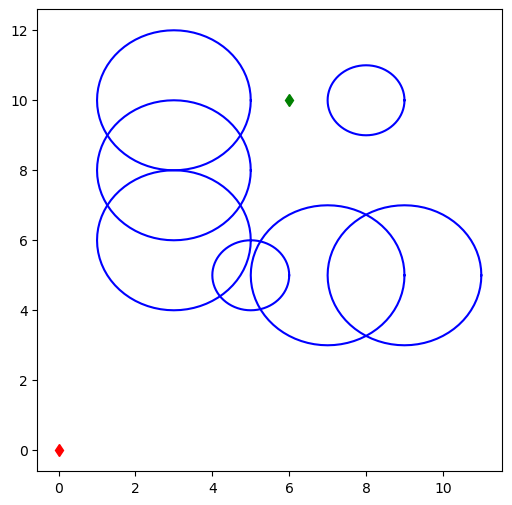

In [10]:
# Punto inicial
S = [0., 0.]
# Punto objetivo
G = [6.0, 10.0]

# Lista de obstáculos circulares: [x, y, radio]
obstacleList = [(5, 5, 1), (3, 6, 2), (3, 8, 2), (3, 10, 2), (7, 5, 2), (9, 5, 2), (8, 10, 1)]

# Gráfico de los obstáculos (círculos), punto inicial y punto final
plt.figure(figsize=(6,6))
plt.plot(S[0], S[1], 'dr')    # Punto inicial
plt.plot(G[0], G[1], 'dg')    # Punto final
for (ox, oy, size) in obstacleList:
    RRT.plot_circle(ox, oy, size)

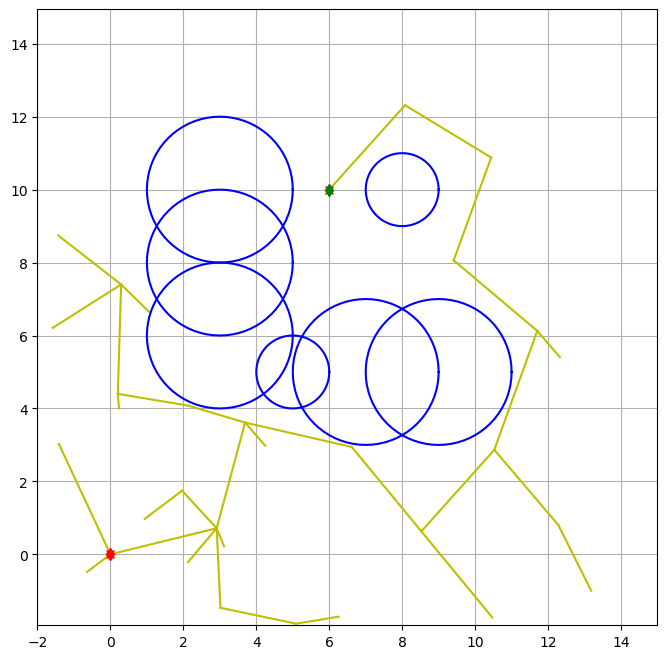

In [11]:
# Objeto RRT
rrt = RRT(start=S, goal=G, rand_area=[-2, 15], obstacle_list=obstacleList)

# Planeamiento de trayectoria del punto inicial al punto final usando RRT
path = rrt.planning()

# Gráfico de los bordes generados usando RRT
plt.figure(figsize=(8,8))
rrt.draw_graph()

plt.plot(S[0], S[1], 'dr')    # Punto inicial
plt.plot(G[0], G[1], 'dg')    # Punto final

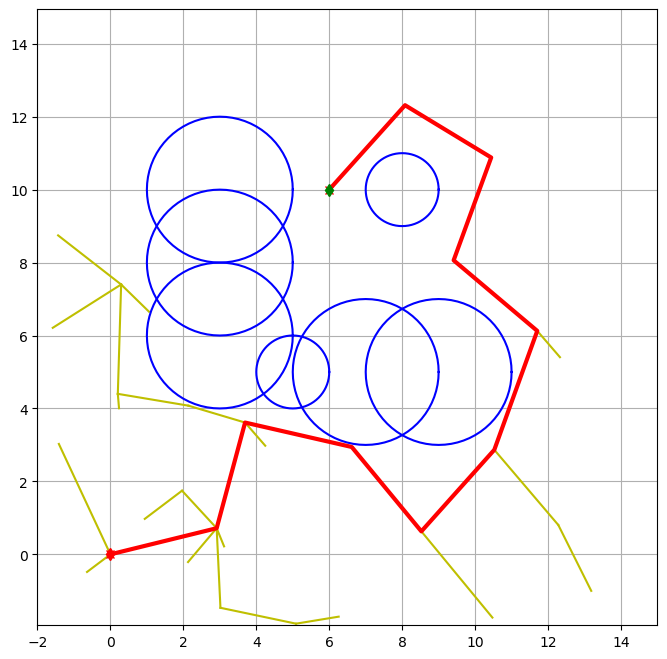

In [12]:
plt.figure(figsize=(8,8))

# Gráfio de bordes generados usando RRT
rrt.draw_graph()
# Gráfico del camino encontrado (en rojo)
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r', linewidth=3.0)

plt.plot(S[0], S[1], 'dr')    # Punto inicial
plt.plot(G[0], G[1], 'dg')    # Punto final

plt.show()

In [17]:
%matplotlib qt

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [ ]:
# Solo correr esta línea si se descomenta qt en la línea anterior

if (True):
    path = rrt.planning(animation=True)
    if path is None:
        print("No se pudo encontrar un camino")
    else:
        print("Camino encontrado")
    rrt.draw_graph()
    plt.pause(1)
    plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r', linewidth=3)
    plt.grid(True)
    plt.show()

### Suavizamiento del Camino

In [ ]:
def get_path_length(path):
    le = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = np.sqrt(dx * dx + dy * dy)
        le += d
    return le

def get_target_point(path, targetL):
    le = 0
    ti = 0
    lastPairLen = 0
    for i in range(len(path) - 1):
        dx = path[i + 1][0] - path[i][0]
        dy = path[i + 1][1] - path[i][1]
        d = np.sqrt(dx * dx + dy * dy)
        le += d
        if le >= targetL:
            ti = i - 1
            lastPairLen = d
            break

    partRatio = (le - targetL) / lastPairLen
    x = path[ti][0] + (path[ti + 1][0] - path[ti][0]) * partRatio
    y = path[ti][1] + (path[ti + 1][1] - path[ti][1]) * partRatio
    return [x, y, ti]

def line_collision_check(first, second, obstacleList):
    # Line Equation
    x1 = first[0]
    y1 = first[1]
    x2 = second[0]
    y2 = second[1]
    try:
        a = y2 - y1
        b = -(x2 - x1)
        c = y2 * (x2 - x1) - x2 * (y2 - y1)
    except ZeroDivisionError:
        return False

    for (ox, oy, size) in obstacleList:
        d = abs(a * ox + b * oy + c) / (np.sqrt(a * a + b * b))
        if d <= size:
            return False
    return True  # OK

def path_smoothing(path, max_iter, obstacle_list):
    le = get_path_length(path)
    for i in range(max_iter):
        # Sample two points
        pickPoints = [random.uniform(0, le), random.uniform(0, le)]
        pickPoints.sort()
        first = get_target_point(path, pickPoints[0])
        second = get_target_point(path, pickPoints[1])
        if first[2] <= 0 or second[2] <= 0:
            continue
        if (second[2] + 1) > len(path):
            continue
        if second[2] == first[2]:
            continue
        # Collision check
        if not line_collision_check(first, second, obstacle_list):
            continue
        # Create New path
        newPath = []
        newPath.extend(path[:first[2] + 1])
        newPath.append([first[0], first[1]])
        newPath.append([second[0], second[1]])
        newPath.extend(path[second[2] + 1:])
        path = newPath
        le = get_path_length(path)

    return path

### Camino suavizado

In [ ]:
# Suavizamiento del camino
maxIter = 1000
smoothedPath = path_smoothing(path, maxIter, obstacleList)

plt.figure(figsize=(8,8))
# Graficar los bordes generados con RRT
rrt.draw_graph()
# Graficar el camino generado con RRT
plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')

# Camino suavizado
plt.plot([x for (x, y) in smoothedPath], [
    y for (x, y) in smoothedPath], '-c', linewidth=4)

plt.grid(True)
plt.show()